### Analyse des taux de croissance

/Users/heticcours/Desktop/Test/myenv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Aperçu des données extraites :
      country                 indicator        date  total_value
0     Estonia  Daily hospital occupancy  2020-01-06          1.0
1     Estonia  Daily hospital occupancy  2020-01-18          1.0
2     Estonia  Daily hospital occupancy  2020-02-12          1.0
3  Luxembourg       Daily ICU occupancy  2020-02-24          0.0
4     Estonia  Daily hospital occupancy  2020-02-25          1.0


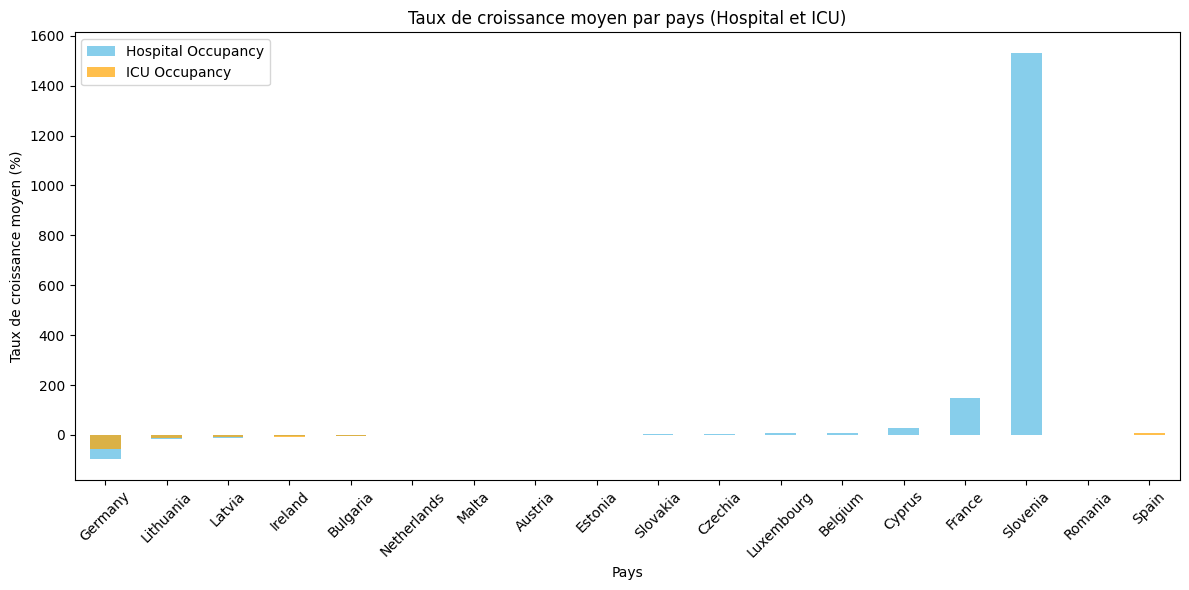

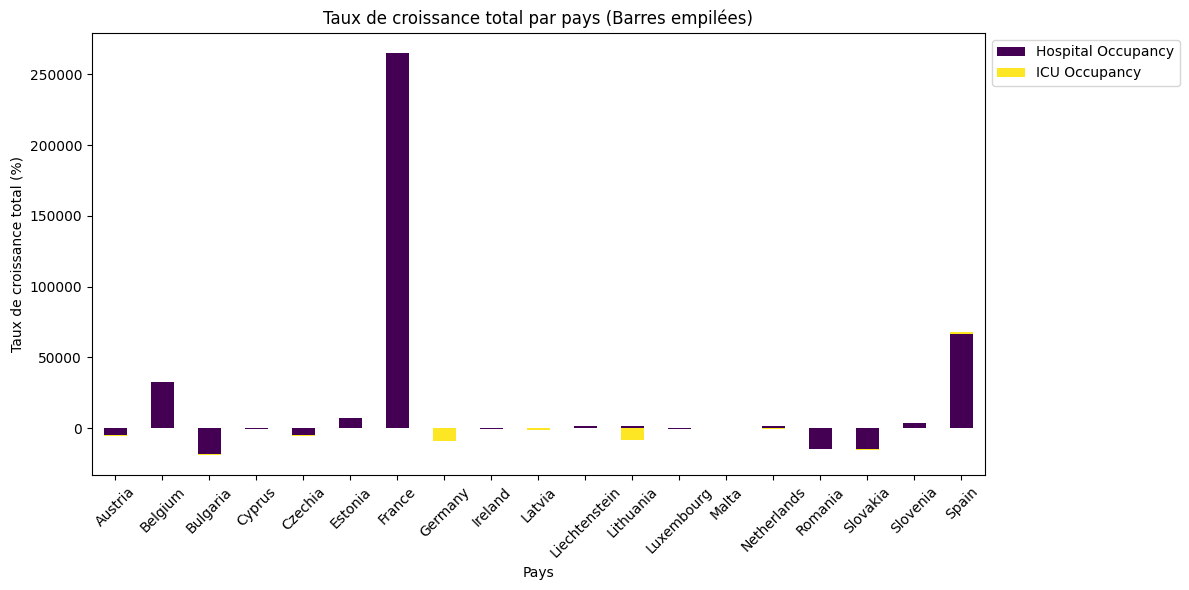

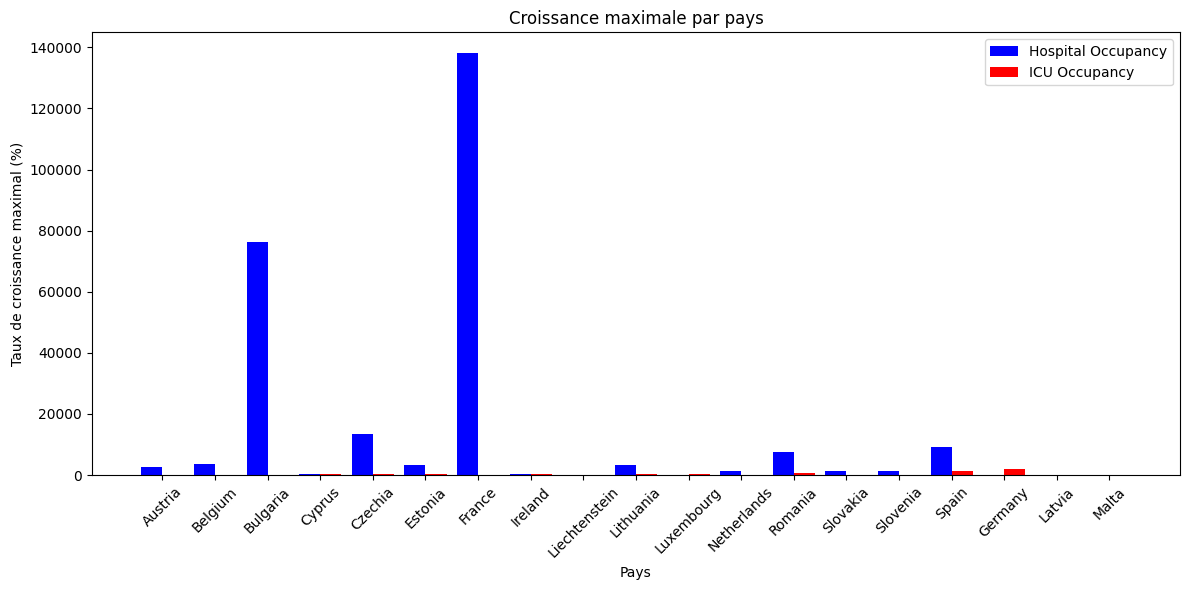

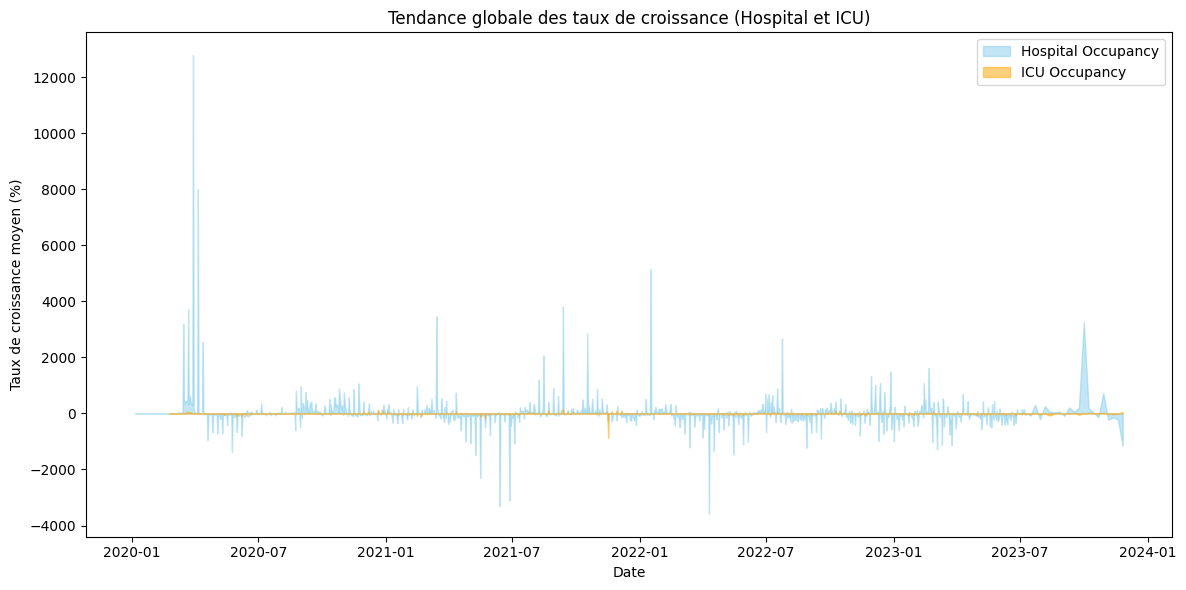

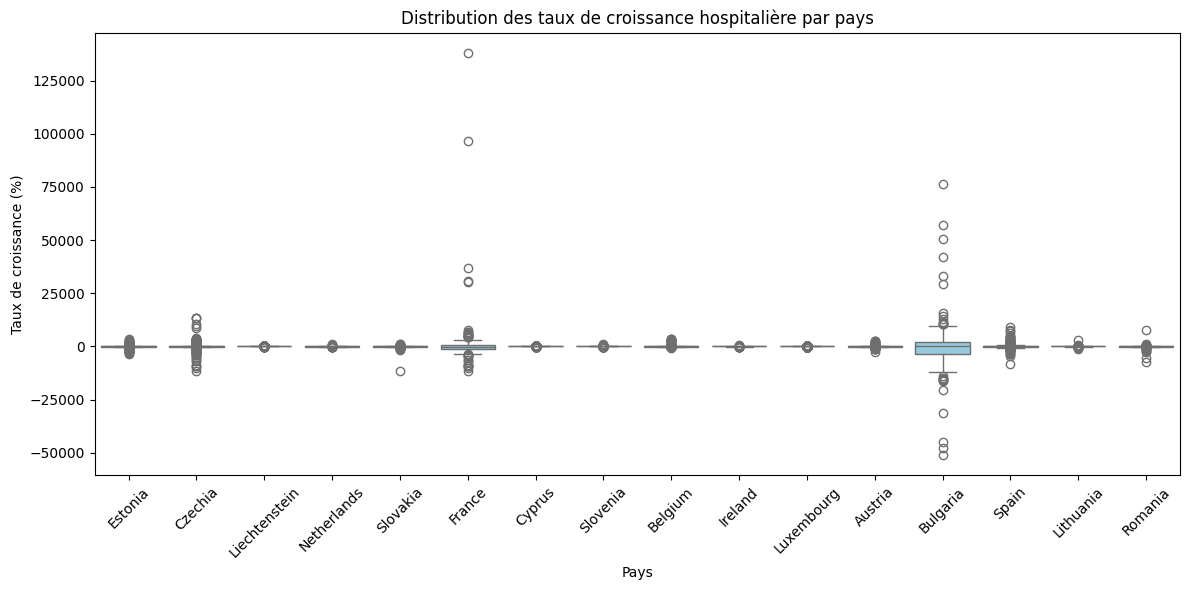

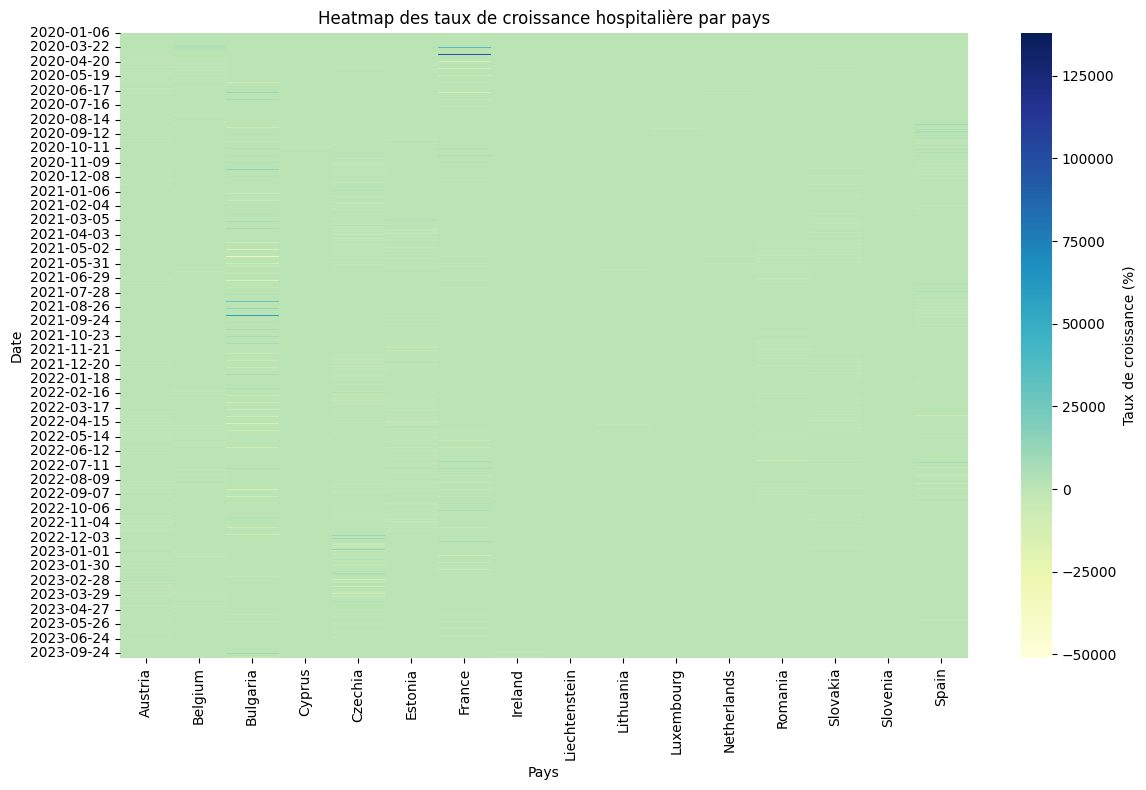

In [7]:
from google.cloud import bigquery
import pandas as pd
import os
import matplotlib.pyplot as plt

# Configurer la clé JSON pour l'authentification
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "my-project-tp-447313-0e2643cb1f3b.json"

# Initialiser le client BigQuery
client = bigquery.Client()

# Requête pour extraire les données pour 'Daily hospital occupancy' et 'Daily ICU occupancy'
query_analysis = f"""
SELECT 
    country,
    indicator,
    DATE(date) AS date,
    SUM(value) AS total_value
FROM `my-project-tp-447313.myprojecttp447313.covid_data`
WHERE indicator IN ('Daily hospital occupancy', 'Daily ICU occupancy')
GROUP BY country, indicator, DATE(date)
ORDER BY date
"""

# Exécuter la requête
query_job = client.query(query_analysis)
analysis_data = query_job.to_dataframe()

# Vérifier les données extraites
print("Aperçu des données extraites :")
print(analysis_data.head())

# Calcul des taux de croissance journaliers
analysis_data['daily_change'] = analysis_data.groupby(['country', 'indicator'])['total_value'].diff()
analysis_data['growth_rate'] = (analysis_data['daily_change'] / analysis_data['total_value'].shift(1)) * 100

# Remplacer les valeurs infinies et NaN par 0
analysis_data['growth_rate'] = analysis_data['growth_rate'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Filtrer par indicateur pour les analyses spécifiques
hospital_data = analysis_data[analysis_data['indicator'] == 'Daily hospital occupancy']
icu_data = analysis_data[analysis_data['indicator'] == 'Daily ICU occupancy']

# ========================
# Graphique 1 : Taux de croissance moyen par pays (Barres)
# ========================
mean_growth_hospital = hospital_data.groupby('country')['growth_rate'].mean()
mean_growth_icu = icu_data.groupby('country')['growth_rate'].mean()

plt.figure(figsize=(12, 6))
mean_growth_hospital.sort_values().plot(kind='bar', color='skyblue', label='Hospital Occupancy')
mean_growth_icu.sort_values().plot(kind='bar', color='orange', alpha=0.7, label='ICU Occupancy')

plt.title("Taux de croissance moyen par pays (Hospital et ICU)")
plt.xlabel("Pays")
plt.ylabel("Taux de croissance moyen (%)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# ========================
# Graphique 2 : Taux de croissance total par pays (Barres empilées)
# ========================
total_growth_hospital = hospital_data.groupby('country')['growth_rate'].sum()
total_growth_icu = icu_data.groupby('country')['growth_rate'].sum()

stacked_growth = pd.DataFrame({
    'Hospital Occupancy': total_growth_hospital,
    'ICU Occupancy': total_growth_icu
}).fillna(0)

stacked_growth.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')

plt.title("Taux de croissance total par pays (Barres empilées)")
plt.xlabel("Pays")
plt.ylabel("Taux de croissance total (%)")
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# ========================
# Graphique 3 : Croissance maximale par pays (Colonnes côte à côte)
# ========================
# Calculer la croissance maximale par pays pour chaque indicateur
max_growth_hospital = hospital_data.groupby('country')['growth_rate'].max()
max_growth_icu = icu_data.groupby('country')['growth_rate'].max()

# Aligner les indices pour les deux séries
aligned_max_growth = pd.concat([max_growth_hospital, max_growth_icu], axis=1, keys=['Hospital Occupancy', 'ICU Occupancy']).fillna(0)

# Recréer les séries alignées
aligned_max_growth_hospital = aligned_max_growth['Hospital Occupancy']
aligned_max_growth_icu = aligned_max_growth['ICU Occupancy']

# Graphique des colonnes côte à côte
width = 0.4
countries = aligned_max_growth.index
x = range(len(countries))

plt.figure(figsize=(12, 6))
plt.bar(x, aligned_max_growth_hospital, width=width, label='Hospital Occupancy', color='blue')
plt.bar([p + width for p in x], aligned_max_growth_icu, width=width, label='ICU Occupancy', color='red')

plt.title("Croissance maximale par pays")
plt.xlabel("Pays")
plt.ylabel("Taux de croissance maximal (%)")
plt.xticks([p + width / 2 for p in x], countries, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# ========================
# Graphique 4 : Tendance globale des taux de croissance (Aires)
# ========================
global_growth_hospital = hospital_data.groupby('date')['growth_rate'].mean()
global_growth_icu = icu_data.groupby('date')['growth_rate'].mean()

plt.figure(figsize=(12, 6))
plt.fill_between(global_growth_hospital.index, global_growth_hospital, color='skyblue', alpha=0.5, label='Hospital Occupancy')
plt.fill_between(global_growth_icu.index, global_growth_icu, color='orange', alpha=0.5, label='ICU Occupancy')

plt.title("Tendance globale des taux de croissance (Hospital et ICU)")
plt.xlabel("Date")
plt.ylabel("Taux de croissance moyen (%)")
plt.legend()
plt.tight_layout()
plt.show()

# ========================
# Graphique 5 : Boxplot des taux de croissance par pays
# ========================
plt.figure(figsize=(12, 6))
sns.boxplot(data=hospital_data, x='country', y='growth_rate', color='skyblue')
plt.title("Distribution des taux de croissance hospitalière par pays")
plt.xlabel("Pays")
plt.ylabel("Taux de croissance (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ========================
# Graphique 6 : Heatmap des taux de croissance moyens par pays et date
# ========================
heatmap_data = hospital_data.pivot(index='date', columns='country', values='growth_rate').fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", cbar_kws={'label': 'Taux de croissance (%)'})
plt.title("Heatmap des taux de croissance hospitalière par pays")
plt.xlabel("Pays")
plt.ylabel("Date")
plt.tight_layout()
plt.show()